In [ ]:
!pip install transformers datasets scikit-learn torch streamlit


Import Libraries and Load Data

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Define labels in exact order
LABELS = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

# Load dataset
df = pd.read_csv("/content/train_data.csv")

# Only keep text + labels
df = df[["comment_text"] + LABELS]

# Split features and labels
X = df["comment_text"].values
y = df[LABELS].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Tokenization (Toxic-BERT)

In [ ]:
from transformers import AutoTokenizer

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("unitary/toxic-bert")

# Tokenize text
def tokenize_texts(texts, max_length=128):
    return tokenizer(
        list(texts),
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

train_encodings = tokenize_texts(X_train)
test_encodings = tokenize_texts(X_test)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Create Dataset for PyTorch

In [ ]:
import torch

class ToxicDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}, self.labels[idx]

train_dataset = ToxicDataset(train_encodings, y_train)
test_dataset = ToxicDataset(test_encodings, y_test)

Load Toxic-BERT Model

In [ ]:

from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "unitary/toxic-bert",
    num_labels=len(LABELS),
    problem_type="multi_label_classification"
)

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: unitary/toxic-bert
Key                          | Status     |  | 
-----------------------------+------------+--+-
bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Training Setup

In [ ]:
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.nn import BCEWithLogitsLoss

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Loss
criterion = BCEWithLogitsLoss()

Training Loop

In [ ]:
import torch

# Take a tiny subset for demo
X_train_small = X_train[:30]
y_train_small = y_train[:30]

# Re-tokenize the tiny subset
train_encodings_small = tokenizer(list(X_train_small), padding=True, truncation=True, max_length=64, return_tensors="pt")

# Tiny dataset
class TinyToxicDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.float32)
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}, self.labels[idx]

train_dataset_small = TinyToxicDataset(train_encodings_small, y_train_small)

# DataLoader
train_loader_small = torch.utils.data.DataLoader(train_dataset_small, batch_size=8, shuffle=True)

# Optimizer & loss
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.BCEWithLogitsLoss()

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Fine-tune 1–2 epochs on tiny dataset
for epoch in range(2):
    model.train()
    for batch in train_loader_small:
        inputs, labels = batch
        inputs = {k: v.to(device) for k, v in inputs.items()}
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(**inputs).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Tiny fine-tune epoch {epoch+1} completed")

print("Demo fine-tuning done!")

Tiny fine-tune epoch 1 completed
Tiny fine-tune epoch 2 completed
Demo fine-tuning done!


Evaluation Metrics

In [ ]:
X_test_small = X_test[:100]   # taking only 100 examples
y_test_small = y_test[:100]

# Re-tokenize
test_encodings_small = tokenizer(list(X_test_small), padding=True, truncation=True, max_length=64, return_tensors="pt")
test_dataset_small = ToxicDataset(test_encodings_small, y_test_small)
test_loader_small = torch.utils.data.DataLoader(test_dataset_small, batch_size=32)

# Evaluation loop
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in test_loader_small:
        inputs, labels = batch
        inputs = {k: v.to(device) for k, v in inputs.items()}
        labels = labels.to(device)
        outputs = model(**inputs).logits
        preds = torch.sigmoid(outputs).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(labels.cpu().numpy())

import numpy as np
all_preds = np.vstack(all_preds)
all_labels = np.vstack(all_labels)
all_preds_bin = (all_preds >= 0.5).astype(int)

from sklearn.metrics import f1_score
print("Micro F1:", f1_score(all_labels, all_preds_bin, average="micro"))
print("Macro F1:", f1_score(all_labels, all_preds_bin, average="macro"))

Micro F1: 0.6666666666666666
Macro F1: 0.43671240208242107


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Save Model

In [29]:
model.save_pretrained("/content/toxic-bert-model")
tokenizer.save_pretrained("/content/toxic-bert-tokenizer")

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

('/content/toxic-bert-tokenizer/tokenizer_config.json',
 '/content/toxic-bert-tokenizer/tokenizer.json')

accuracy precision scores


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

# Subset Accuracy (exact match across all labels)
subset_acc = accuracy_score(all_labels, all_preds_bin)
print(" Accuracy (all labels match):", subset_acc)

# Micro metrics (aggregate over all labels)
micro_prec = precision_score(all_labels, all_preds_bin, average="micro")
micro_rec = recall_score(all_labels, all_preds_bin, average="micro")
print("Micro Precision:", micro_prec)
print("Micro Recall:", micro_rec)

# Macro metrics (average across labels)
macro_prec = precision_score(all_labels, all_preds_bin, average="macro")
macro_rec = recall_score(all_labels, all_preds_bin, average="macro")
print("Macro Precision:", macro_prec)
print("Macro Recall:", macro_rec)

# Per-label metrics (classification report)
labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
report = classification_report(all_labels, all_preds_bin, target_names=labels)
print("\nPer-label Metrics:\n", report)

 Accuracy (all labels match): 0.84
Micro Precision: 0.5365853658536586
Micro Recall: 0.88
Macro Precision: 0.37662337662337664
Macro Recall: 0.5404040404040404

Per-label Metrics:
                precision    recall  f1-score   support

        toxic       0.50      0.91      0.65        11
 severe_toxic       0.00      0.00      0.00         0
      obscene       0.55      1.00      0.71         6
       threat       0.00      0.00      0.00         0
       insult       0.71      0.83      0.77         6
identity_hate       0.50      0.50      0.50         2

    micro avg       0.54      0.88      0.67        25
    macro avg       0.38      0.54      0.44        25
 weighted avg       0.56      0.88      0.68        25
  samples avg       0.08      0.10      0.09        25



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

In [ ]:
pip install matplotlib

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


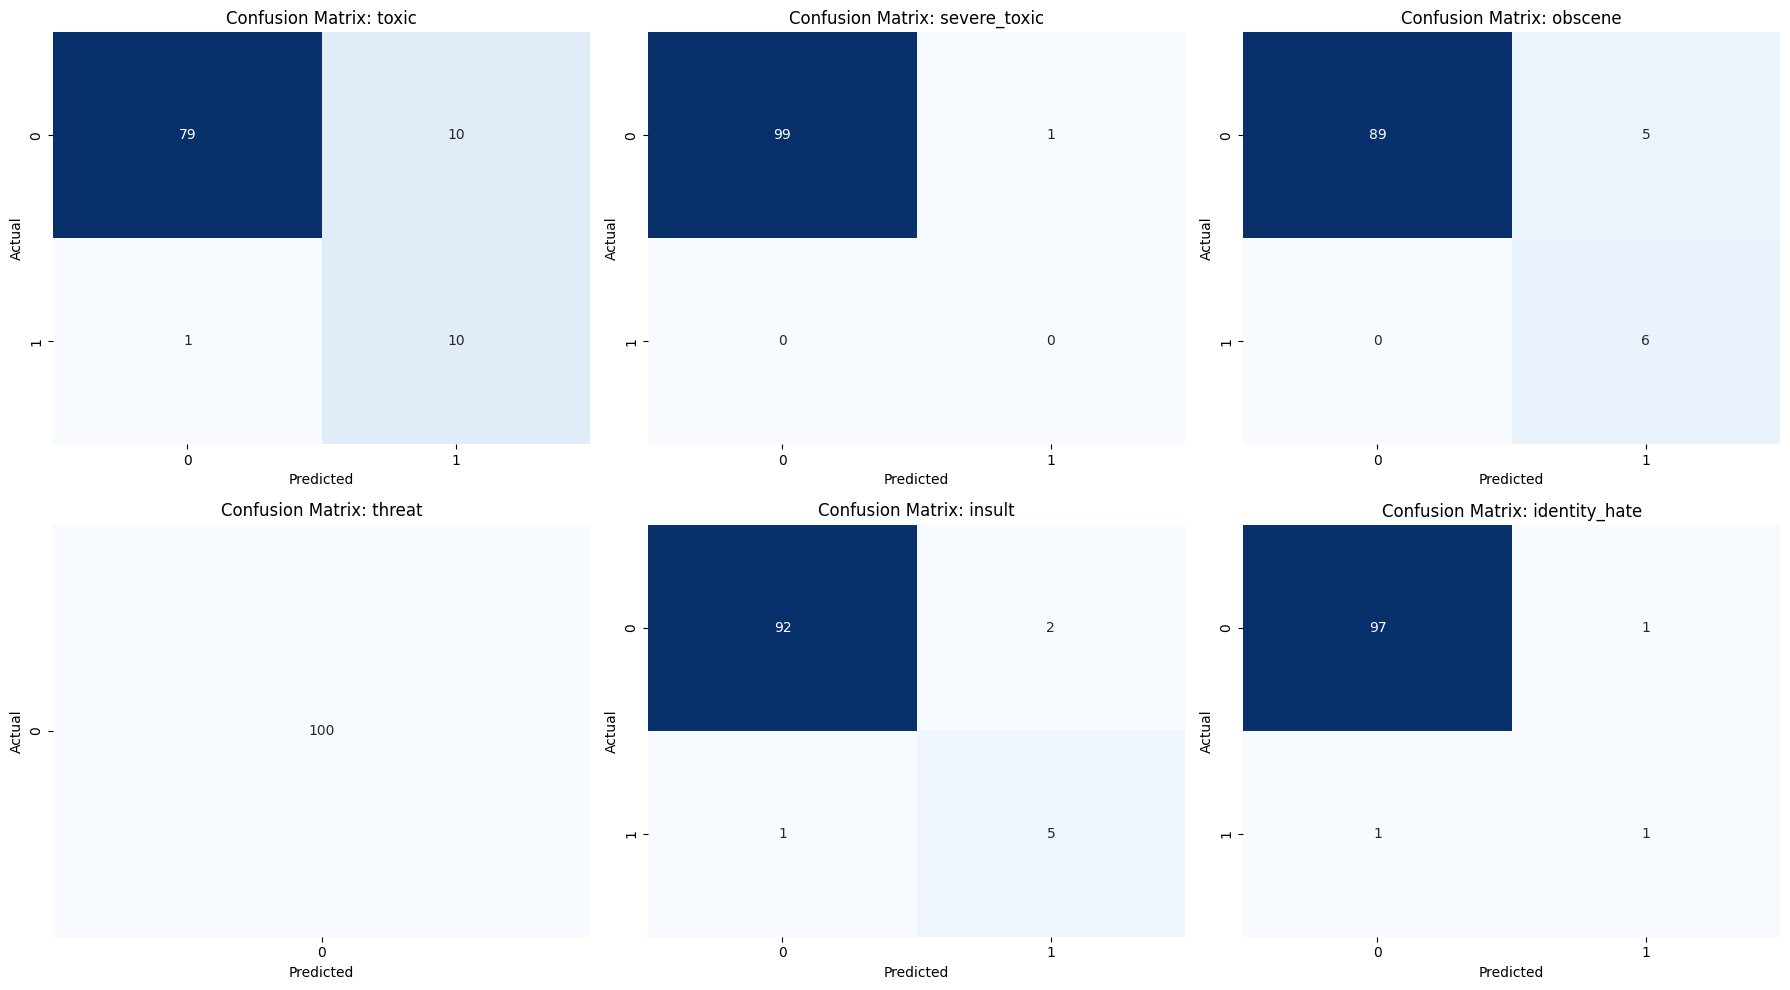

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

plt.figure(figsize=(18, 10))

for i, label in enumerate(labels):
    cm = confusion_matrix(all_labels[:, i], all_preds_bin[:, i])
    plt.subplot(2, 3, i+1)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix: {label}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


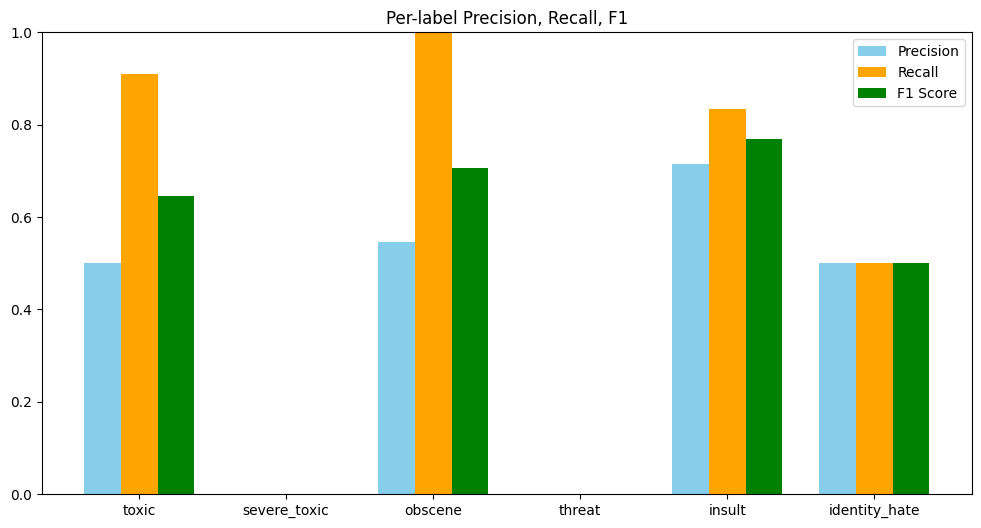

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Calculate per-label metrics
precisions = precision_score(all_labels, all_preds_bin, average=None)
recalls = recall_score(all_labels, all_preds_bin, average=None)
f1s = f1_score(all_labels, all_preds_bin, average=None)

x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(12,6))
plt.bar(x - width, precisions, width, label='Precision', color='skyblue')
plt.bar(x, recalls, width, label='Recall', color='orange')
plt.bar(x + width, f1s, width, label='F1 Score', color='green')
plt.xticks(x, labels)
plt.ylim(0,1)
plt.title("Per-label Precision, Recall, F1")
plt.legend()
plt.show()

/tmp/ipython-input-1958292696.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=pred_sums, palette="viridis")


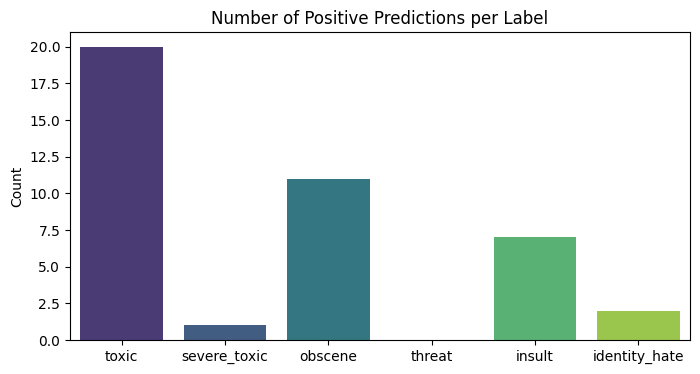

In [ ]:
pred_sums = all_preds_bin.sum(axis=0)
plt.figure(figsize=(8,4))
sns.barplot(x=labels, y=pred_sums, palette="viridis")
plt.title("Number of Positive Predictions per Label")
plt.ylabel("Count")
plt.show()